### Stars of the Hipparcos Catalog
#### Writing an efficient Python code 

Having fast and reliable computational tools and algorithms is extremely important when working with large data sets. In Python, this is achieved by using tools, such as Pandas and Numpy arrays, and by writing readable and efficient codes in the so-called Pythonic way.  

In this notebook, we will explore an astronomical data set from the Hipparcos catalog using Panda's DataFrames. Although, there are larger and more precise astronomical catalogs, the Hipparcos database remains a good source of information for students trying to understand the distance scale of the Universe and the nature of the famous HR diagram. 

The Hipparcos catalog was produced by the Hipparcos satellite (HIgh Precision PARallax COllecting Satellite), launched in 1989 by the European Space Agency to measure distances to the stars with higher precision than the previous methods (<a href="https://www.cosmos.esa.int/web/hipparcos/catalogues">Hipparcos</a>).

The original data set includes over 70 columns containing information related to the stars' positions, distances, and spectral types. However, for this notebook, we will use only the following ten columns:  

<ul>    
<li> Hip_No - unique Hipparcos number </li>
<li> Alpha (h,m,s) - right ascension is one of the stellar coordinates on the sky</li>
<li> Delta (d,m,s) - declination is another stellar coordinate</li> 
<li> Vmag - visual magnitude is a measure of the apparent stellar brightness   
<li> Plx - trigonometric parallax in milliarcseconds is a small apparent angular shift in the position of a star on the sky due to Earth's motion around the Sun </li>
<li> e_Plx - standard error in Plx in milliarcseconds </li>
<li> B-V - color index is an indicator of the stellar color </li>
<li> e_B-V - the standard error for B-V color
<li> n_CCDM - Historical status flag for the multiple stellar systems. Any of the following letters: H, I, or M indicate that an object is a system including more stars orbiting around each other </li>   
<li> Spectral_type - a spectral type of an object is a measure of the stellar temperature and color </li>
</ul>

### 1. Importing and preparing data 

First, we will import data from the Hipparcos catalog into a DataFrame and prepare numerical columns. By selecting only the single stars from the dataset, we can recognize various distinct features of the HR diagram and observe how the temperature and the brightness of the stars change throughout their lives. 

*Note: use 'coerce' to set the invalid parsing to 'NaN'. Use 'loc' attribute as the fastest way of selecting a subframe from an input DataFrame*

In [1]:
#importing Python libraries
import numpy as np
import pandas as pd

file = '../data/hip_sp.csv'

#defining column names
new_column_names = ['Hip_No', 'Alpha', 'Delta','Vmag','Plx', 'e_Plx', 'B-V','e_B-V', 'ccdm_h','Spectral_type']

#importing data
hip_all_stars = pd.read_csv(file, header = None, sep =',',
                usecols = [1,2,3,4,5,6,7,8,9,10],  
                names = new_column_names,
                low_memory = False)

#changing column types
col_list = ['Vmag', 'Plx', 'e_Plx', 'B-V', 'e_B-V']
for  col in col_list:
   hip_all_stars[col] = pd.to_numeric(hip_all_stars[col],  errors = 'coerce') 

#selecting only single stars with no ccdm_h flag
df = hip_all_stars.loc[hip_all_stars['ccdm_h']==' ']

#dropping ccdm_h column
hip = df.drop(['ccdm_h'], axis = 1) 

#displaying DataFrame
hip.head(5)

,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,F5
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,K3V
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,F0V
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,G8III
5,6,00 00 04.35,+03 56 47.4,12.31,18.80,4.99,1.336,0.020,M0V:


### 2. Examining dataset

By examining our DataFrame, we can see that most columns contain 118218 non-null values and that four columns have some rows with null values. These are the stars that do not have measured trigonometric parallaxes and B-V color index. Moreover, the input DataFrame is a combination of numeric and non-numeric columns. First, we will add two additional columns into the input DataFrame: the absolute stellar magnitude (Mv) and the stellar distance (d). 

In [2]:
#displaying input DataFrame summary 
hip_all_stars.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118218 entries, 0 to 118217
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Hip_No         118218 non-null  int64  
 1   Alpha          118218 non-null  object 
 2   Delta          118218 non-null  object 
 3   Vmag           118217 non-null  float64
 4   Plx            117955 non-null  float64
 5   e_Plx          117955 non-null  float64
 6   B-V            116937 non-null  float64
 7   e_B-V          116937 non-null  float64
 8   ccdm_h         118218 non-null  object 
 9   Spectral_type  118218 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 9.0+ MB


### 3.  Finding absolute stellar magnitudes


If we want to study stars from the Hipparcos catalog and create an HR diagram, we need to find the absolute stellar magnitude (Mv), representing the star's real brightness. The absolute magnitude can be calculated using the apparent magnitude (Vmag) and the trigonometric parallax (Plx) from the Hipparcos catalog. 

The apparent magnitude (Vmag) shows how bright is an object observed from Earth. The Vmag values are determined by the object's real brightness and distance from Earth and by the amount of interstellar dust between a star and the observer. On the other hand, the absolute magnitude is equal to the star's apparent magnitude if an object is placed at a distance of 10 parsecs from Earth. Therefore using the absolute magnitude we can compare real stellar luminosities of different stars. 

In addition, the trigonometric parallax (Plx) is a measure of the stellar distance using a simple relation that: $$Distance(in\ parsecs) = 1/ Plx (in\ arcseconds)$$.  The Plx values are usually small, positive numbers, but they can also appear as large or negative numbers due to errors in measurements or factors such as the crowded regions of the sky. Hence we will first clean our DataFrame from the stars with the negative parallaxes and negative distances. We will also exclude those stars whose errors in the measured parallaxes are larger than the actual parallaxes. 

*Note: Use the .copy() command when creating a new DataFrame to explicitly tell Pandas that we are making a copy of a DataFrame. Use timeit Python library to time the code. Check the Python documentation  (<a href="https://docs.python.org/3/library/timeit.html">Timeit</a>)*

In [3]:
#import timeit library
import timeit

#number of stars with no measured parallaxes
no_plx = hip['Plx'].isnull().sum()
print('Number of stars without measured parallaxes:{}'.format(no_plx))

#number of stars with negative parallaxes
negative_plx= sum([plx<0 for plx in hip['Plx'].values])
print('Number of stars with negative parallaxes:{}'.format(negative_plx) )

#selecting stars with positive Plx and with the relative errors in Plx < 0.80
hip_stars = hip.loc[(hip['Plx']>0) & (hip['e_Plx']/hip['Plx'].abs()<0.80)].copy()
code = '''hip_stars = hip.loc[(hip['Plx']>0) & (hip['e_Plx']/hip['Plx'].abs()<0.80)].copy()'''
print('Time for filtering DataFrame: {} sec'.format(timeit.timeit(stmt=code, number=1, globals={'hip':hip})))

#DataFrame with positive parallaxes
print(hip_stars.shape)

Number of stars without measured parallaxes:61
Number of stars with negative parallaxes:3390
Time for filtering DataFrame: 0.012947299999999995 sec
(85480, 9)


In [4]:
#creating a new column with the absolute magnitude
%timeit -r2 -n10 hip_stars['Mv'] = hip_stars['Vmag'] + 5 - 5*np.log10(1000/hip_stars['Plx'])

#rounding numbers
hip_stars = hip_stars.round({'Mv': 2})

print(hip_stars.shape)

2.8 ms ± 295 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
(85480, 10)


### 4. Calculating stellar distances


We can calculate stellar distances directly from the measured stellar parallaxes as Distance = (1/𝑃𝑙𝑥) × 1000, where the parallax from the Hipparcos catalog is given in milliarcseconds (an angle thousand times smaller than 1 arcsecond), and the distance is calculated in parsecs (pc).

A parsec is a unit for the length used in astronomy for measuring large distances. One parsec contains over 30 trillion kilometers. It  is defined as the distance to an object at which Earth's orbit around the Sun, would be seen at a very small angle of 1 arcsecond. An arcsecond is an angle equal to 1/3600 of a degree. By expressing the stellar distances in parsecs, the distance column of the DataFrame does not include very large or very small numbers.  

*Note: Use Python's built-in function round() to round numbers. Python's built-in functions are the fastest way of performing a specific task.*

In [5]:
#creating a new column for stellar distance
hip_stars['Distance'] = (1/hip_stars['Plx'])*1000

hip_stars= hip_stars.round({'Distance': 2})

print(hip_stars.shape)
hip_stars.head(5)

(85480, 11)


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type,Mv,Distance
0,1,00 00 00.22,+01 05 20.4,9.10,3.54,1.39,0.482,0.025,F5,1.85,282.49
1,2,00 00 00.91,-19 29 55.8,9.27,21.90,3.10,0.999,0.002,K3V,5.97,45.66
3,4,00 00 02.01,-51 53 36.8,8.06,7.75,0.97,0.370,0.009,F0V,2.51,129.03
4,5,00 00 02.39,-40 35 28.4,8.55,2.87,1.11,0.902,0.013,G8III,0.84,348.43
5,6,00 00 04.35,+03 56 47.4,12.31,18.80,4.99,1.336,0.020,M0V:,8.68,53.19


### 5. Exploring stars from the catalog (Part I)

After adding two new columns to the DataFrame, we can explore the catalog and find the brightest and the most distant stars, as well as the stars similar to our Sun. 

First, we will compare the star's apparent and absolute magnitudes.
We will consider all-stars for this part. When observed from the Hipparcos satellite, the brightest star has the Hipparcos number 32349 and an apparent magnitude of -1.44. The magnitude scale is defined in the reversed orders, meaning that the smaller and negative numbers correspond to the brighter stars. The star with the Hipparcos number 32349 is Sirius, a well-known star from the constellation Canis Major (the Great Dog). Sirius is the brightest star in the night sky, and it is also a binary system having the Hipparcos ccdm_h flag. 

*Note: Use parameter 'globals' in timeit to give the timit module access to the global variables*

In [6]:
#finding a star with the largest apparent magnitude
display(hip_all_stars.nsmallest(1,'Vmag'))

#finding a star with the smallest apparent magnitude
display(hip_all_stars.nlargest(1,'Vmag'))

#finding the brightest star in the catalogue 
display(hip_stars.nsmallest(1,'Mv'))

code = '''hip_stars.nsmallest(1,'Mv')'''
print('Time for searching through DataFrame: {} sec'.format(timeit.timeit(stmt=code, number=1, globals={'hip_stars':hip_stars})))


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type
32324,32349,06 45 09.25,-16 42 47.3,-1.44,379.21,1.58,0.009,0.007,I,A0m...


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,ccdm_h,Spectral_type
70015,70079,14 20 28.21,-44 31 56.3,14.08,-20.09,12.63,NaN,NaN,,


,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type,Mv,Distance
34417,34444,07 08 23.49,-26 23 35.5,1.83,1.82,0.56,0.671,0.019,F8Ia,-6.87,549.45


Time for searching through DataFrame: 0.00916119999999987 sec


### 6. Exploring stars from the catalog (Part II)


Although Sirius appears to be the brightest star in the catalog, the most luminous star in our selected sample is a star with the Hipparcos number 34444. This object is Delta Canis Majoris from the same constellation as Sirius but with the absolute magnitude of -6.87. The absolute magnitude of Sirius is +1.4. Hip34444 is a yellow supergiant of F8Ia spectral type. The star is located at a distance of about 549 parsecs.

What are the most distant stars in the Hipparcos database? A blue hot supergiant of A2 spectral type with the Hipparcos number 107418, Nu Cephei,  is one of the most distant stars recorded in the catalog. From the selected list we can notice that the most distant stars have negative absolute magnitudes (Mv).  

How many stars in the catalog are more luminous than our Sun having the absolute magnitude of Mv = 4.8? 

*Note: If we want to extract a list from a column of a DataFrame, using a DataFrame directly is faster than using the list method*

In [7]:
#selecting the most distant stars
display(hip_stars.sort_values(by=['Distance'], ascending = False).head(3))

#selecting stars brighter than Sun
bright_df = hip_stars[hip_stars['Mv'] < 4.8]

print('Number of stars brighter than the Sun:{}'.format(bright_df.shape[0]))

#creating a list of Hipparcos numbers for stars brighter than Sun

%timeit -r2 -n10 Hip_list1 = [bright_df['Hip_No']]

%timeit -r2 -n10 Hip_list2 = list(bright_df['Hip_No'])

,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type,Mv,Distance
107322,107418,21 45 26.93,+61 07 14.9,4.25,0.64,0.47,0.474,0.004,A2Iavar,-6.72,1562.50
48694,48730,09 56 21.90,-51 20 10.2,6.39,0.70,0.53,-0.162,0.005,B2IV-V,-4.38,1428.57
108676,108772,22 02 04.58,+58 00 01.3,5.55,0.70,0.46,0.017,0.005,O9V,-5.22,1428.57


Number of stars brighter than the Sun:77968
The slowest run took 12.54 times longer than the fastest. This could mean that an intermediate result is being cached.
10.4 µs ± 8.89 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
6.98 ms ± 35.7 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


### 7. Spectral type of the Hipparcos stars

The spectral type is one of the most important characteristics of a star. According to the stellar spectra, stars are classified into seven main groups, using the letters O, B, A, F, G, K, and M, and for each group, ten subgroups using the numbers 0 to 9 with the O type stars being the hottest and the M type stars the coolest ones. The classification was further filtered by adding the luminosity class for supergiants (I), the main sequence stars (V), the white dwarf stars (VII), and so on.

We can explore the spectral types of stars from the Hipparcos catalog in many different ways. For example, we can group the stars into spectral groups and count the numbers for each spectral type. 

*Note: The fastest way to count how many stars belong to each spectral group is by using a special Python object called Counter. This is faster than using the groupby method.* 

In [8]:
#importing Counter
from collections import Counter

#counting using groupby
%timeit -r2 -n10  hip_all_stars.groupby(['Spectral_type']).count()

#counting using Counter
Sp_list = hip_all_stars['Spectral_type'].str.rstrip()
counter_dict = Counter(Sp_list)
%timeit -r2 -n10 counter_dict = Counter(Sp_list)

#listing the most common spectral groups 
print('The most common spectral groups:',counter_dict.most_common(3))
print('Number of different groups:{}'.format(len(counter_dict)))

31.3 ms ± 74 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
15.5 ms ± 107 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
The most common spectral groups: [('K0', 8570), ('G5', 6017), ('A0', 4944)]
Number of different groups:4125


### 8. Finding Sun like stars in the catalog

From the spectral classifications of the Hipparcos stars, we can see that there are over 4000 different groups and that K0, G5, and A0 spectral types have the largest number of stars. 

What about selecting a list of stars with the same spectral type as our Sun?
To create the Sun-like list of stars, we need to filter DataFrame based on the'Spectral_type' column. The Sun's spectral type is 'G2V'. 

*Note: Use str. contains() function for the fastest substring search with regex = False if the use of the regular expressions is not required*

In [9]:
from statistics import mean

#filtering stars of the G2V class
hip_sunlike = hip_stars[hip_stars['Spectral_type'].str.contains('G2V', regex = False) ]

%timeit -r2 -n10  hip_sunlike = hip_stars[hip_stars['Spectral_type'].str.contains('G2V', regex = False) ]

#average absolute magnitude
sunlike_avg = mean(hip_sunlike['Mv'])

print('The average absolute magnitude of the sun-like stars:', 
      round(sunlike_avg, 2), end='\n\n')
display(hip_sunlike.head(5))
print(hip_sunlike.shape)

15 ms ± 36.8 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
The average absolute magnitude of the sun-like stars: 4.0



,Hip_No,Alpha,Delta,Vmag,Plx,e_Plx,B-V,e_B-V,Spectral_type,Mv,Distance
79,80,00 00 58.03,-11 49 24.7,8.40,15.59,1.43,0.566,0.015,G2V,4.36,64.14
393,394,00 04 53.21,+34 39 34.4,6.09,27.18,4.30,0.632,0.011,G2V,3.26,36.79
680,682,00 08 25.69,+06 37 00.5,7.59,25.15,0.97,0.626,0.015,G2V,4.59,39.76
706,705,00 08 47.38,+86 47 16.4,8.41,16.24,0.70,0.588,0.013,G2V,4.46,61.58
844,846,00 10 22.97,-13 59 02.9,8.92,13.53,1.28,0.578,0.003,G2V,4.58,73.91


(551, 11)


### 9. The HR - diagram 

The Hertzsprung-Russell (HR) diagram presents the change in the stellar luminosity, absolute magnitude (Mv), with the spectral type (temperature) expressed through the B-V color index. The HR diagram is one of the most important tools in astronomy, allowing astronomers to follow and study stars through different stages of stellar evolution. 

We will now plot Hipparcos stars on the HR diagram by filtering the most prominent stellar groups. We will also over-plot positions for the stars we found earlier in the notebook, such as the most luminous star and the most distant star.  

In [10]:
#defining function for the plot
def HR_plot(col_x, col_y, x_start, x_end, y_start, y_end, clr):
    x = col_x
    y = col_y
    plt.plot(x, y, marker='.', linestyle='none', markersize=2, color=clr)
    plt.xlim(x_start,x_end)
    plt.ylim(y_start,y_end)
    plt.xlabel('B-V')
    plt.ylabel('Mv')
    plt.title('Hipparcos Hertzsprung-Russell Diagram')

In [11]:
#plotting HR diagram 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#selecting stars with the relative errors in parallax: e_Plx/abs(Plx) < 10 %
hip1 = hip_stars.loc[(hip_stars['e_Plx']/hip_stars['Plx'].abs())<0.10]

hip_plot = hip1.loc[hip1['B-V']< 2]

In [12]:
#HR_plot(hip_plot['B-V'], hip_plot['Mv'], -0.5, 2.5, 15,-5, 'blue')

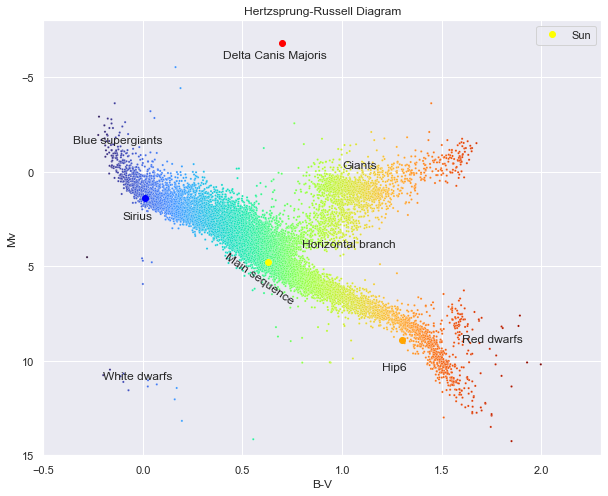

In [13]:
#marking selected stars
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x ='B-V', y ='Mv', data = hip_plot, hue ='B-V', size ='B-V', sizes = (5,5), palette='turbo')

plt.ylim(15,-8)
plt.xlim(-0.5,2.3)
plt.title('Hertzsprung-Russell Diagram')
plt.annotate('Main sequence', xy=(0.4,7.0), rotation = -35)
plt.annotate('Giants', xy=(1.0,-0.2))
plt.annotate('Horizontal branch ', xy=(0.8,4.0))
plt.annotate('White dwarfs', xy=(-0.2,11.0))
plt.annotate('Red dwarfs', xy=(1.6,9.0))
plt.annotate('Blue supergiants', xy=(-0.35,-1.5))
plt.annotate('Sirius', xy=(-0.1,2.5))
plt.annotate('Delta Canis Majoris', xy=(0.4,-6.0))
plt.annotate('Hip6', xy=(1.2,10.5))

#Sun's position at 0.63, 4.8
yellow_dot = plt.plot(0.63,4.8, marker='o', color='yellow', linestyle='none')
plt.legend(yellow_dot, ['Sun'])
#other stars
blue_dot = plt.plot(0.009,1.4, marker='o', color='blue', linestyle='none')
red_dot = plt.plot(0.7,-6.8, marker='o', color='red', linestyle='none')
orange_dot = plt.plot(1.3,8.9, marker='o', color='orange', linestyle='none')

While building this notebook, we learned about the stars, and worked with some of the most efficient features of the Python programming language, such as the list comprehension, slicing, calculating, and filtering DataFrames, using the counter, and creating a plot with many dots.